# Mapping to Pre-built Symphony References

Last updated August 30, 2021.

In this tutorial, we will show how to map new query datasets onto pre-built Symphony references.

References available for download on [Zenodo](https://zenodo.org/record/5090425#.YOqe_hNKhTY):

| Reference atlas | Filename | Num cells | Description
| --- | ----------- | --------- | ----
| **10x PBMCs Atlas** | pbmcs_10x_reference.rds | 20,571 cells | Healthy human PBMCs sequenced with three 10x protocols (3'v1, 3'v2, and 5')
| **Pancreatic Islet Cells Atlas** | pancreas_plate-based_reference.rds | 5,887 cells from 32 donors | Human pancreatic islet cells from four separate studies (Segerstolpe et al., Lawlor et al., Grun et al., Muraro et al.)
| **Fetal Liver Hematopoeisis Atlas** | fetal_liver_reference_3p.rds | 113,063 cells from 14 donors | Human fetal liver cells (from Popescu et al., 2019), sequenced with 10x (3')
| **Healthy Fetal Kidney Atlas** | kidney_healthy_fetal_reference.rds | 27,203 cells from 6 samples | Healthy human fetal kidney cells (from Stewart et al., 2019).
| **Memory T Cell (CITE-seq) Atlas** | tbru_ref.rds | 500,089 cells from 259 donors | Memory T cells from a tuberculosis cohort assayed with CITE-seq (Nathan et al., 2021)
| **Cross-tissue Fibroblast Atlas** | fibroblast_atlas.rds | 79,148 cells from 74 samples | Human fibroblasts across inflammatory diseases in the lung, gut, synovium, and salivary gland (Korsunsky et al., 2021)
| **Cross-tissue Inflammatory Immune Atlas** | zhang_reference.rds | 307,084 immune cells from 125 donors | Human immune cells across 6 inflammatory diseases (from Zhang et al., 2021)
| **Tabula Muris Senis (FACS) Atlas** | TMS_facs_reference.rds | 110,824 cells from 19 mice | Mouse cells across 23 tissues and organs

To read in a reference into R, one may simply execute: `reference = readRDS('path/to/reference_name.rds')`

**Notes:** 
* In order to map query cells onto the reference UMAP coordinates (e.g. to visualize reference and query cells together), you will need to save the path to the corresponding reference 'uwot_model' file in the reference object's `ref$save_uwot_path` slot in order to load the uwot model for query mapping. This is due to a technicality of how the uwot package saves and loads UMAP models. If you only wish to map the query cells into the harmonized reference embedding (and compute your own separate UMAP embedding for visualization), you may ignore this step.
* All reference datasets in this tutorial were normalized using the log(CP10k+1) method. During query mapping, a key assumption is that the reference and query are normalized in the same manner. Symphony can automatically log-normalize the query by setting `do_normalize = TRUE` (by default), but if you are using a reference normalized using another method (e.g. SCTransform), then be sure to normalize the query in the same way before calling `mapQuery` and set `do_normalize = FALSE`.

## Imports

Visit https://github.com/immunogenomics/symphony for information about installing Symphony.

In [1]:
#devtools::install_github("immunogenomics/symphony", dep = FALSE) # whether to update dependencies

In [2]:
suppressPackageStartupMessages({
    library(symphony)
    library(singlecellmethods)
    library(tidyverse)
    library(data.table)
    library(matrixStats)
    library(Matrix)
    library(plyr)
    library(dplyr)
    
    # Plotting
    library(ggplot2)
    library(ggthemes)
    library(ggrastr)
    library(RColorBrewer)
    library(patchwork)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

In [3]:
source('../pre-built_references/colors.R') # color palette definitions

# Loading the 10x PBMCs Atlas

This section gives an example of how to load and plot a Symphony reference. Here, we load in an integrated reference of PBMCs sequenced using different 10x technologies.

First, download the reference from Zenodo and place it in a directory named 'pre-built_references' (do this for every reference of interest).

In [4]:
# Read in saved reference
ref_pbmcs = readRDS('../pre-built_references/pbmcs_10x_reference.rds')

To plot the reference as density plots, use the `plotReference` function with `as.density = TRUE`.

Adding missing grouping variables: `cell_type`



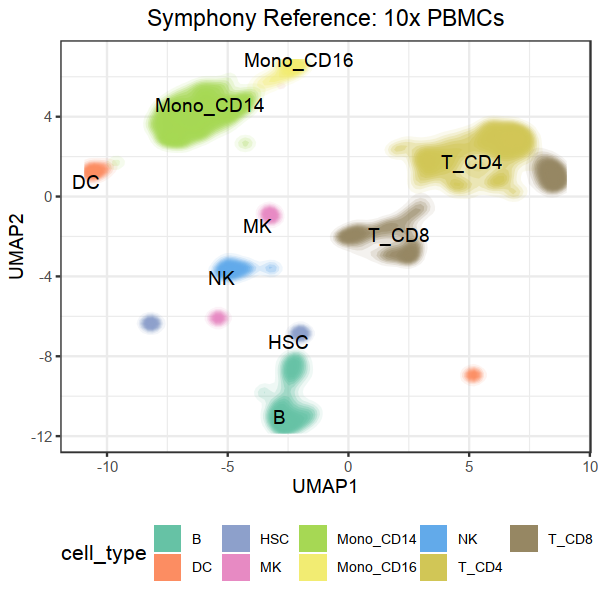

In [5]:
fig.size(5, 5)
p = plotReference(ref_pbmcs,
                   as.density = TRUE,      # plot density or individual cells
                   bins = 14,              # if density, nbins parameter for stat_density_2d
                   bandwidth = 1,        # if density, bandwidth parameter for stat_density_2d
                   title = "Symphony Reference: 10x PBMCs",    # Plot title
                   color.by = 'cell_type', # metadata column name for cell type labels
                   celltype.colors = pbmc_colors, # custom color palette
                   show.legend = TRUE,     # Show cell type legend
                   show.labels = TRUE,     # Show cell type labels
                   show.centroids = FALSE) # Plot soft cluster centroid locations)
p

To plot the reference as individual points, use the `plotReference` function with `as.density = FALSE`.

Adding missing grouping variables: `cell_type`



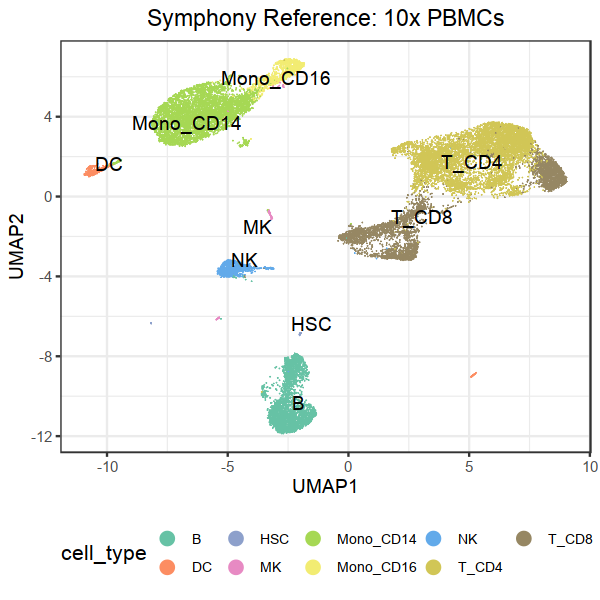

In [6]:
fig.size(5, 5)
p = plotReference(ref_pbmcs,
                   as.density = FALSE,      # plot density or individual cells
                   title = "Symphony Reference: 10x PBMCs",    # Plot title
                   color.by = 'cell_type', # metadata column name for cell type labels
                   celltype.colors = pbmc_colors, # custom color palette
                   show.legend = TRUE,     # Show cell type legend
                   show.labels = TRUE,     # Show cell type labels
                   show.centroids = FALSE) # Plot soft cluster centroid locations)
p

Let's take a look at what is included in each reference object:

In [7]:
str(ref_pbmcs)

List of 12
 $ meta_data     :'data.frame':	20571 obs. of  11 variables:
  ..$ cell_id         : chr [1:20571] "threepfresh_AAACCTGAGCATCATC" "threepfresh_AAACCTGAGCTAACTC" "threepfresh_AAACCTGAGCTAGTGG" "threepfresh_AAACCTGCACATTAGC" ...
  ..$ donor           : chr [1:20571] "3pv2" "3pv2" "3pv2" "3pv2" ...
  ..$ nUMI            : int [1:20571] 2394 1694 4520 2788 4667 4440 3224 5205 5493 4419 ...
  ..$ nGene           : int [1:20571] 871 806 1316 898 1526 1495 1253 1433 1632 1134 ...
  ..$ percent_mito    : num [1:20571] 0.0384 0.0573 0.0195 0.014 0.0362 ...
  ..$ pub_cell_type   : chr [1:20571] "bcells" "mono" "tcells" "tcells" ...
  ..$ pub_res0.8      : int [1:20571] 3 5 2 1 0 0 6 4 0 4 ...
  ..$ pub_cell_subtype: chr [1:20571] "bnaive" "mono14" "cd4mem" "cd4naive" ...
  ..$ nnk5_res0.8     : chr [1:20571] "4" "1" "2" "0" ...
  ..$ cell_type       : chr [1:20571] "B" "Mono_CD14" "T_CD4" "T_CD4" ...
  ..$ cell_type_broad : chr [1:20571] "B" "Mono" "T" "T" ...
 $ vargenes      : tibbl

The `meta_data` slot contains cell type annotations and other information.

In [8]:
ref_pbmcs$meta_data %>% head(3)

,cell_id,donor,nUMI,nGene,percent_mito,pub_cell_type,pub_res0.8,pub_cell_subtype,nnk5_res0.8,cell_type,cell_type_broad
,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
1,threepfresh_AAACCTGAGCATCATC,3pv2,2394,871,0.03842941,bcells,3,bnaive,4,B,B
2,threepfresh_AAACCTGAGCTAACTC,3pv2,1694,806,0.05726092,mono,5,mono14,1,Mono_CD14,Mono
3,threepfresh_AAACCTGAGCTAGTGG,3pv2,4520,1316,0.01946903,tcells,2,cd4mem,2,T_CD4,T


The `Z_corr` slot contains the harmonized reference embedding.

In [9]:
ref_pbmcs$Z_corr %>% t() %>% head(4) # transposed here for ease of viewing

,harmony_1,harmony_2,harmony_3,harmony_4,harmony_5,harmony_6,harmony_7,harmony_8,harmony_9,harmony_10,harmony_11,harmony_12,harmony_13,harmony_14,harmony_15,harmony_16,harmony_17,harmony_18,harmony_19,harmony_20
1,3.715223,12.8720190,-4.572770,1.359571,-0.76058192,0.17326255,-0.2016319,-1.91693092,-0.4453194,1.5144909,0.5782115,0.7891299,0.4682987,-0.67203163,0.23649907,-0.9550524,1.6769007,-1.0798225,-1.5683307,3.09021234
2,-11.729734,-0.4484995,2.342819,1.542363,-1.35835303,3.28323907,1.0326952,-3.21242958,0.8043799,0.2933921,-0.4173909,1.8610609,1.7643013,-0.05736554,-0.15419421,-2.8844846,0.2801944,-0.2270381,1.6016730,3.50283090
3,4.403937,-2.9702501,3.771289,-1.386129,0.07124545,-3.43798485,-2.2705996,-0.02212932,-2.7493537,-1.3387109,0.9749829,-0.4619131,-2.3302294,1.37960393,1.69591953,-0.8091332,-0.1833657,0.9279358,0.3238745,1.23166552
4,6.345025,-0.7558881,4.359824,1.371542,-0.34648310,-0.06136858,-0.5818727,-1.44016538,1.2919975,0.1613770,-0.5998466,-0.3536126,-0.5661134,0.63233384,-0.06247994,-0.5791100,-0.5462616,-0.1612937,0.4438445,-0.09744917


# Mapping to Pancreatic Islet Cells Atlas

## Load and view the reference

In this example, the reference consists of human pancreatic islet cells from 4 studies, each using a different plate-based technology.

In [10]:
# Read in saved reference
ref_pancreas = readRDS('../pre-built_references/pancreas_plate-based_reference.rds')

Adding missing grouping variables: `cell_type`



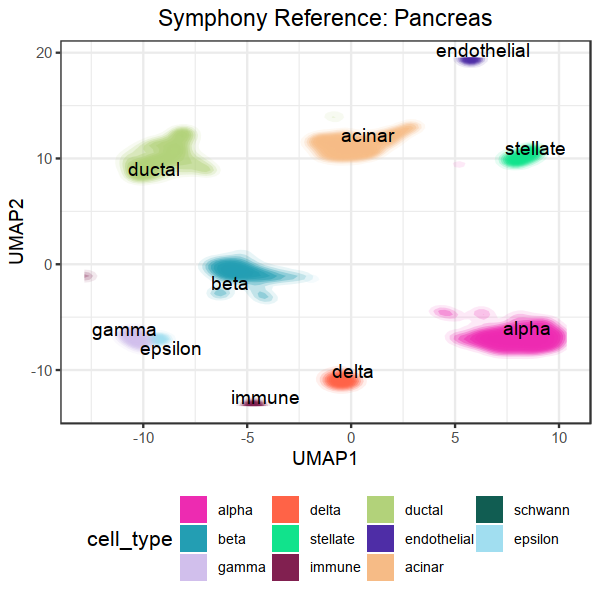

In [11]:
fig.size(5, 5)
p = plotReference(ref_pancreas,
                   as.density = TRUE,      # plot density or individual cells
                   bins = 10,              # if density, nbins parameter for stat_density_2d
                   bandwidth = 1.5,        # if density, bandwidth parameter for stat_density_2d
                   title = "Symphony Reference: Pancreas",    # Plot title
                   color.by = 'cell_type', # metadata column name for cell type labels
                   celltype.colors = pancreas_colors, # custom color palette
                   show.legend = TRUE,     # Show cell type legend
                   show.labels = TRUE,     # Show cell type labels
                   show.centroids = FALSE) # Plot soft cluster centroid locations)
p

## Map an example query dataset

In this example, we will map the Baron et al. (2016) dataset containing human and mouse pancreatic islet cells sequenced using inDrop.

The mouse expression was "humanized" using a custom ortholog mapping (`../data/Fig4_pancreas_multi/ensembl_homologene_human-to-mouse_mapping.rds`) generated from combining ortholog pairs from Ensembl (accessed via biomaRt) and Homologene.

Obtained NCBI Homologene mapping from: https://ftp.ncbi.nih.gov/pub/HomoloGene/build37.2/homologene.data

In [12]:
# Read in normalized expression for human and mouse
human_exp_norm = readRDS('data/pancreas_baron_human_exp.rds')
mouse_exp_norm = readRDS('data/pancreas_baron_mouse_biomart_homologene_exp.rds')

# Read in metadata
human_metadata = readRDS('data/pancreas_baron_human_metadata.rds')
mouse_metadata = readRDS('data/pancreas_baron_mouse_metadata.rds')
human_metadata$species_donor = paste0(human_metadata$species, human_metadata$donor)
mouse_metadata$species_donor = paste0(mouse_metadata$species, mouse_metadata$donor)

dim(human_exp_norm)
human_metadata %>% head(4)
dim(mouse_exp_norm)
mouse_metadata %>% head(4)

[1] 20125  8569

,donor,cell_type1,total_features,cell_type,species,dataset,species_donor
,<dbl>,<fct>,<int>,<fct>,<chr>,<chr>,<chr>
human1_lib1.final_cell_0001,1,acinar,3526,acinar,human,inDrop,human1
human1_lib1.final_cell_0002,1,acinar,4201,acinar,human,inDrop,human1
human1_lib1.final_cell_0003,1,acinar,2119,acinar,human,inDrop,human1
human1_lib1.final_cell_0004,1,acinar,2956,acinar,human,inDrop,human1


[1] 20873  1886

,donor,cell_type1,total_features,cell_type,species,dataset,species_donor
,<dbl>,<fct>,<int>,<fct>,<chr>,<chr>,<chr>
mouse1_lib1.final_cell_0001,1,beta,3205,beta,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0002,1,ductal,3829,ductal,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0003,1,delta,2582,delta,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0004,1,schwann,3041,schwann,mouse,inDrop,mouse1


In [13]:
# To map the human and mouse simultaneously, combine the two sparse matrices
combined_filled <- t(plyr::rbind.fill.matrix(t(mouse_exp_norm), t(human_exp_norm)))
combined_filled[is.na(combined_filled)] = 0 # fill in any missing genes with 0
colnames(combined_filled) = c(rownames(mouse_metadata), rownames(human_metadata))

Perform the mapping

In [14]:
# Symphony mapping
system.time({
query= mapQuery(exp_query = combined_filled, 
                        metadata_query = rbind(mouse_metadata, human_metadata),
                        ref_obj = ref_pancreas,
                        vars = c('dataset', 'species', 'species_donor'), 
                        do_normalize = FALSE)
})

Scaling and synchronizing query gene expression

Found 2236 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



   user  system elapsed 
 13.465   5.864   9.149 

## Plot query after mapping

Plot query in reference UMAP coordinates

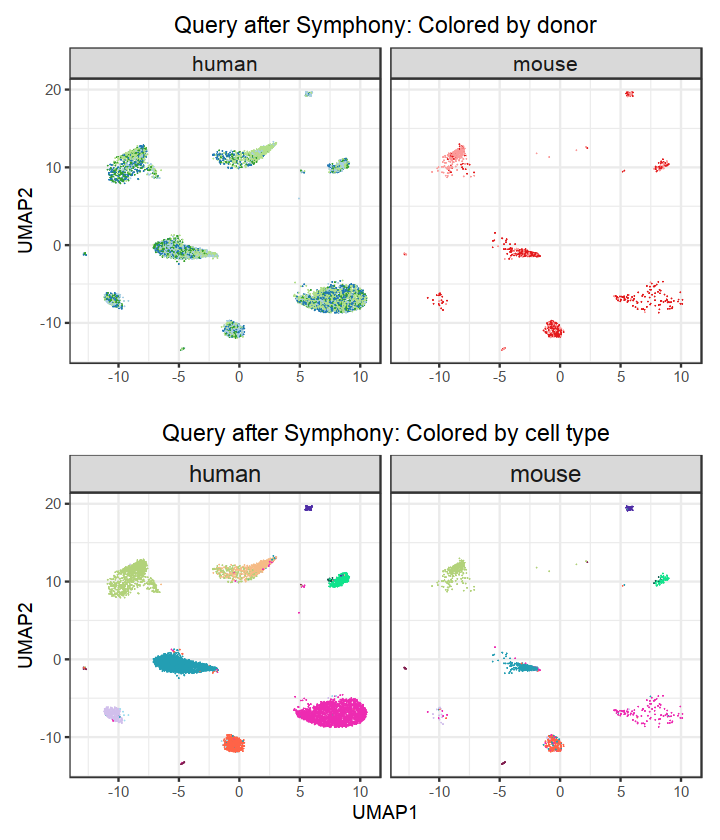

In [15]:
fig.size(7, 6)

# Add UMAP coordinates
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_labels = cbind(query$meta_data, query$umap)

# Plot UMAP visualization
p1 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = species_donor)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Query after Symphony: Colored by donor', color = '') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="none", legend.text = element_text(size=11), legend.title = element_text(size = 12)) +
    scale_colour_brewer(palette = 'Paired') +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 5)) +
    facet_wrap(~species, nrow=1) +
    theme(strip.text.x = element_text(size = 12)) + xlab('')

p2 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Query after Symphony: Colored by cell type', color = '') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="none", legend.text = element_text(size=11), legend.title = element_text(size = 12)) +
    scale_colour_manual(values = pancreas_colors) +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 5)) +
    facet_wrap(~species, nrow=1) + 
    theme(strip.text.x = element_text(size = 14)) 

p1 / p2

# Mapping to Fetal Liver Hematopoiesis Atlas

In this example, the reference consists of human fetal liver cells sequenced with 10x 3' chemistry. We will load this reference then map a query containing fetal liver cells sequenced with 10x 5' chemistry, then infer query cell types from the reference.

## Load and view the reference

In [16]:
# Read in saved reference
ref_fetal_liver = readRDS('../pre-built_references/fetal_liver_reference_3p.rds')

Adding missing grouping variables: `cell.labels`



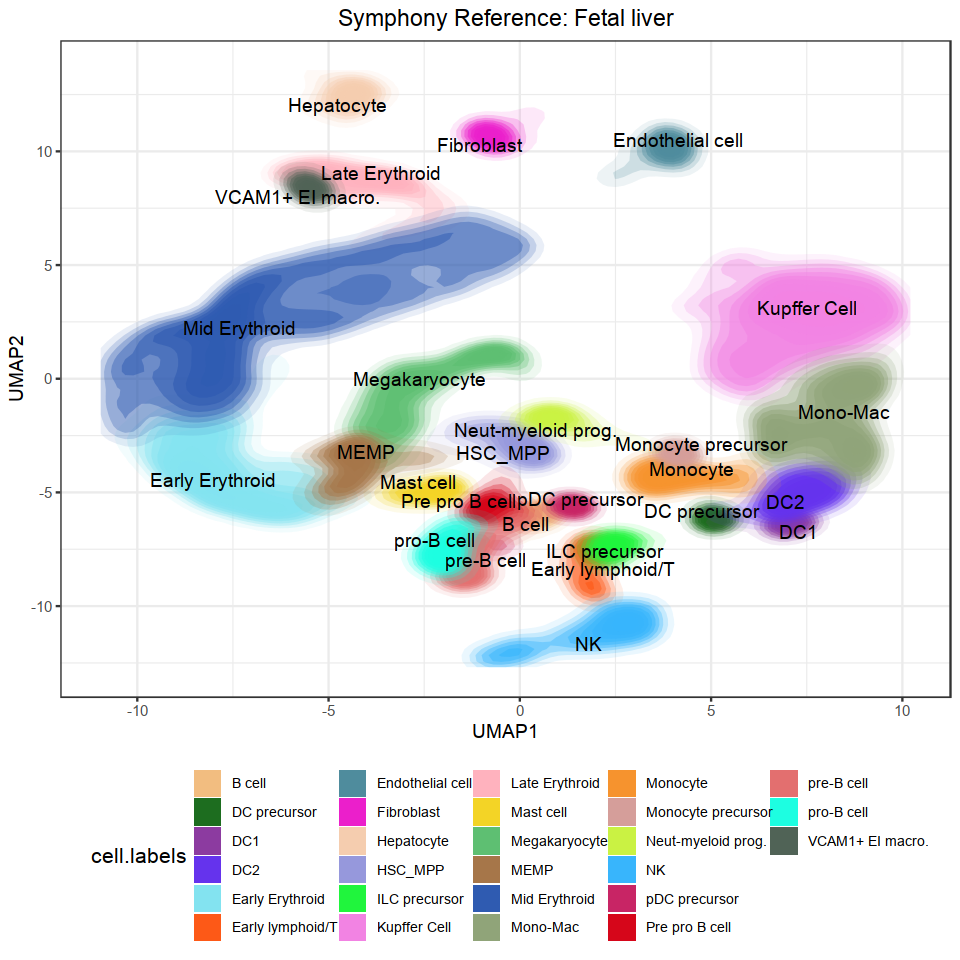

In [17]:
fig.size(8, 8)
p = plotReference(ref_fetal_liver,
                   as.density = TRUE,      # plot density or individual cells
                   bins = 10,              # if density, nbins parameter for stat_density_2d
                   bandwidth = 1.5,        # if density, bandwidth parameter for stat_density_2d
                   title = "Symphony Reference: Fetal liver",    # Plot title
                   color.by = 'cell.labels', # metadata column name for cell type labels
                   celltype.colors = group.colors, # custom color palette
                   show.legend = TRUE,     # Show cell type legend
                   show.labels = TRUE,     # Show cell type labels
                   show.centroids = FALSE) # Plot soft cluster centroid locations)
p

## Map an example query dataset
We will map fetal liver cells sequenced with 10x 5' chemistry onto the atlas of cells sequenced with 3' chemistry.

In [19]:
exprs_5p = readRDS('data/fetal_liver_exprs_5p.rds')
metadata_5p = readRDS('data/fetal_liver_meta_5p.rds') # from authors

In [20]:
metadata_5p$cell.labels = plyr::mapvalues(metadata_5p$cell.labels, 
    from = c('Neutrophil-myeloid progenitor', 'VCAM1+ EI macrophage'),
    to = c('Neut-myeloid prog.', 'VCAM1+ EI macro.')) # Shorter cell type labels
metadata_5p$end.bias = '5prime' # add covariate

The following `from` values were not present in `x`: Neutrophil-myeloid progenitor, VCAM1+ EI macrophage



In [21]:
dim(exprs_5p)
dim(metadata_5p)

[1] 33694 21414

[1] 21414    14

In [22]:
# Map query
ptm <- proc.time()
query = mapQuery(exprs_5p, metadata_5p, ref_fetal_liver, 
                 vars = c('donor', 'end.bias'), 
                 do_normalize = TRUE)
proc.time() - ptm

Normalizing

Scaling and synchronizing query gene expression

Found 1917 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



   user  system elapsed 
 24.619   9.412  14.759 

## Plot query after mapping

Now, we can view our query cells plotted in the reference embedding space.

In [23]:
# Sync column names
r_metadata = ref_fetal_liver$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor', 'pcw')]
q_metadata = query$meta_data[, c('Source.Name', 'cell_barcode', 'cell.labels', 'donor', 'pcw')]
colnames(q_metadata) = colnames(r_metadata)

r_metadata$ref_query = 'reference'
q_metadata$ref_query = q_metadata$donor
meta_data_combined = rbind(q_metadata, r_metadata)

# Add the UMAP coordinates to the metadata
umap_combined = rbind(query$umap, ref_fetal_liver$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

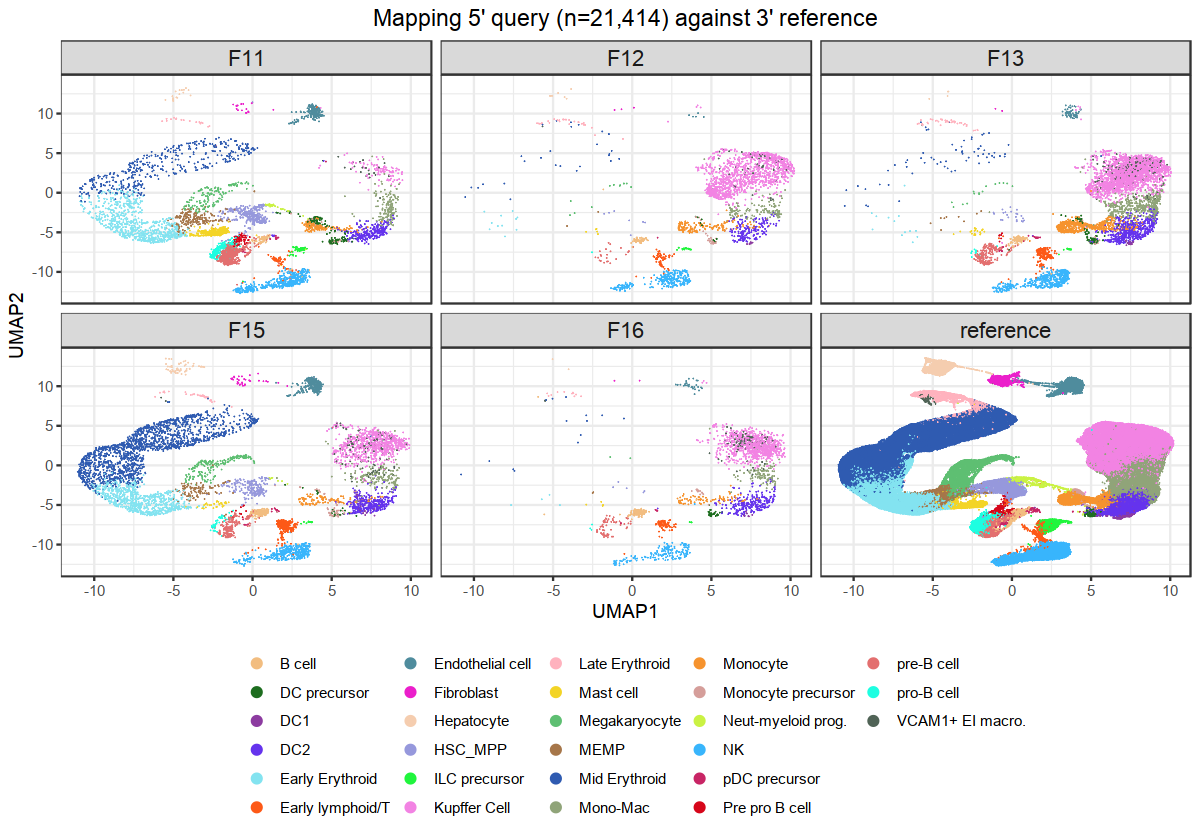

In [24]:
fig.size(7, 10)

q = umap_combined_labels %>%
    mutate(cell.labels = fct_relevel(cell.labels,  
            # Match original author publication ordering of states
            "HSC_MPP", "Pre pro B cell", 'pro-B cell', 'pre-B cell', 'B cell',
            'ILC precursor', 'Early lymphoid/T', 'NK', 'Neut-myeloid prog.',
            'pDC precursor','DC precursor', 'DC1', 'DC2', 'Monocyte precursor', 'Monocyte', 
            'Mono-Mac', 'Kupffer Cell', 'VCAM1+ EI macro.', 'MEMP', 'Mast cell',
            'Megakaryocyte', 'Early Erythroid', 'Mid Erythroid', 'Late Erythroid',
            'Endothelial cell', 'Fibroblast', 'Hepatocyte')) %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell.labels)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Mapping 5\' query (n=21,414) against 3\' reference', color = '') + 
    theme(plot.title = element_text(hjust = 0.5), legend.position="bottom") +
    scale_colour_manual(values = group.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 5)) +
    theme(strip.text.x = element_text(size=13)) +
    facet_wrap(~ref_query)
q

## Cell type annotation transfer


Perform k-NN cell type prediction across 27 fine-grained continuous cell states

In [25]:
# Predict query cell types
query = knnPredict(query, ref_fetal_liver, 
                   train_labels = ref_fetal_liver$meta_data$cell.labels, 
                   k = 30, 
                   confidence = TRUE) # calculate prediction confidence

* Prediction results are stored in `query$meta_data$cell_type_pred_knn`
* Prediction confidence score (proportion of reference neighbors contributing to winning vote) is saved in `query$meta_data$cell_type_pred_knn_prob`

In [26]:
query$meta_data %>% head(4)

,index,cell_barcode,Source.Name,pcw,sex,organ,donor,trimester,facs.sorting,end.bias,num_cells,nGene,cell.labels.public,cell.labels,cell_type_pred_knn,cell_type_pred_knn_prob
,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>
1,FCAImmP7292028AAACCTGCACACTGCG,AAACCTGCACACTGCG,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,2844,Early lymphoid_T lymphocyte,Early lymphoid/T,Early lymphoid/T,0.8666667
2,FCAImmP7292028AAACCTGCATATACGC,AAACCTGCATATACGC,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,3572,Kupffer Cell,Kupffer Cell,Kupffer Cell,1.0000000
3,FCAImmP7292028AAACCTGGTACGACCC,AAACCTGGTACGACCC,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,4644,Kupffer Cell,Kupffer Cell,Kupffer Cell,1.0000000
4,FCAImmP7292028AAACCTGGTAGGACAC,AAACCTGGTAGGACAC,FCAImmP7292028,17 weeks gestation,female,liver,F16,Second trimister,Live/dead sorting,5prime,2223,722,Late Erythroid,Late Erythroid,Late Erythroid,1.0000000


# Loading the Memory T cell CITE-seq atlas

This section demonstrates loading and plotting the memory T-cell CITE-seq atlas (original paper: Nathan et al., 2021). The embedding was built using CCA (capturing both mRNA and protein information rather than PCA).

**Note:** The reference object currently published on Zenodo was built before the publication of the Nathan et al. dataset. Therefore, it does not contain cell type labels or protein expression. These can now be obtained from GEO (GSE158769): https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158769 

You can update the reference metadata directly, such as `ref$meta_data = new_meta_data`.

In [27]:
ref = readRDS('../pre-built_references/tbru_ref.rds')

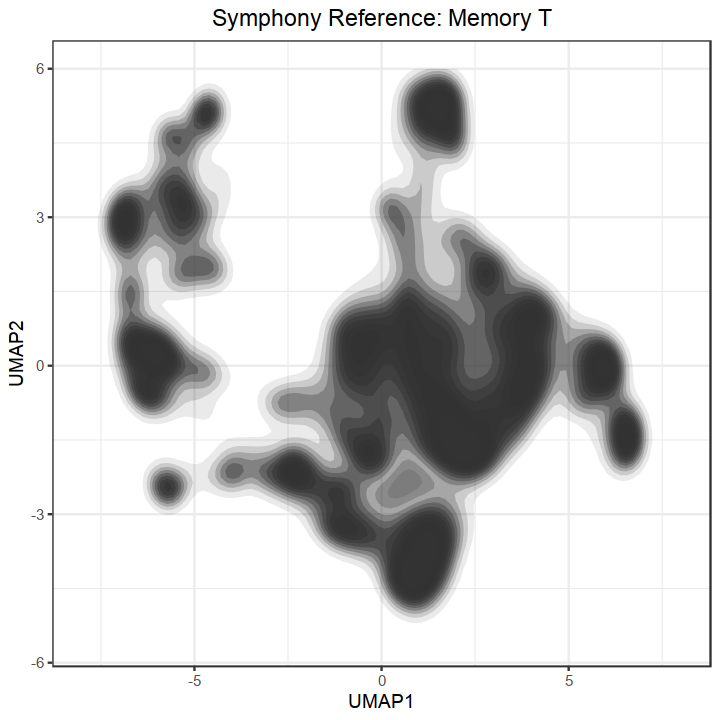

In [28]:
fig.size(6, 6)
p = plotReference(ref,
                   as.density = TRUE,      # plot density or individual cells
                   bins = 14,              # if density, nbins parameter for stat_density_2d
                   bandwidth = 1,          # if density, bandwidth parameter for stat_density_2d
                   title = "Symphony Reference: Memory T",    # Plot title
                   color.by = 'batch',     # metadata column name for cell type labels
                   #celltype.colors = assort.colors, # custom color palette
                   show.legend = TRUE,     # Show cell type legend
                   show.labels = FALSE,    # Show cell type labels
                   show.centroids = FALSE) + # Plot soft cluster centroid locations) 
                lims(x = c(-8, 8), y = c(-5.5, 6))
p

# Loading the Healthy Fetal Kidney Atlas

This section demonstrates loading and plotting the healthy fetal kidney atlas (original paper: Stewart et al., 2019).

In [29]:
ref_kidney = readRDS('../pre-built_references/kidney_healthy_fetal_reference.rds')

Adding missing grouping variables: `cell_type`



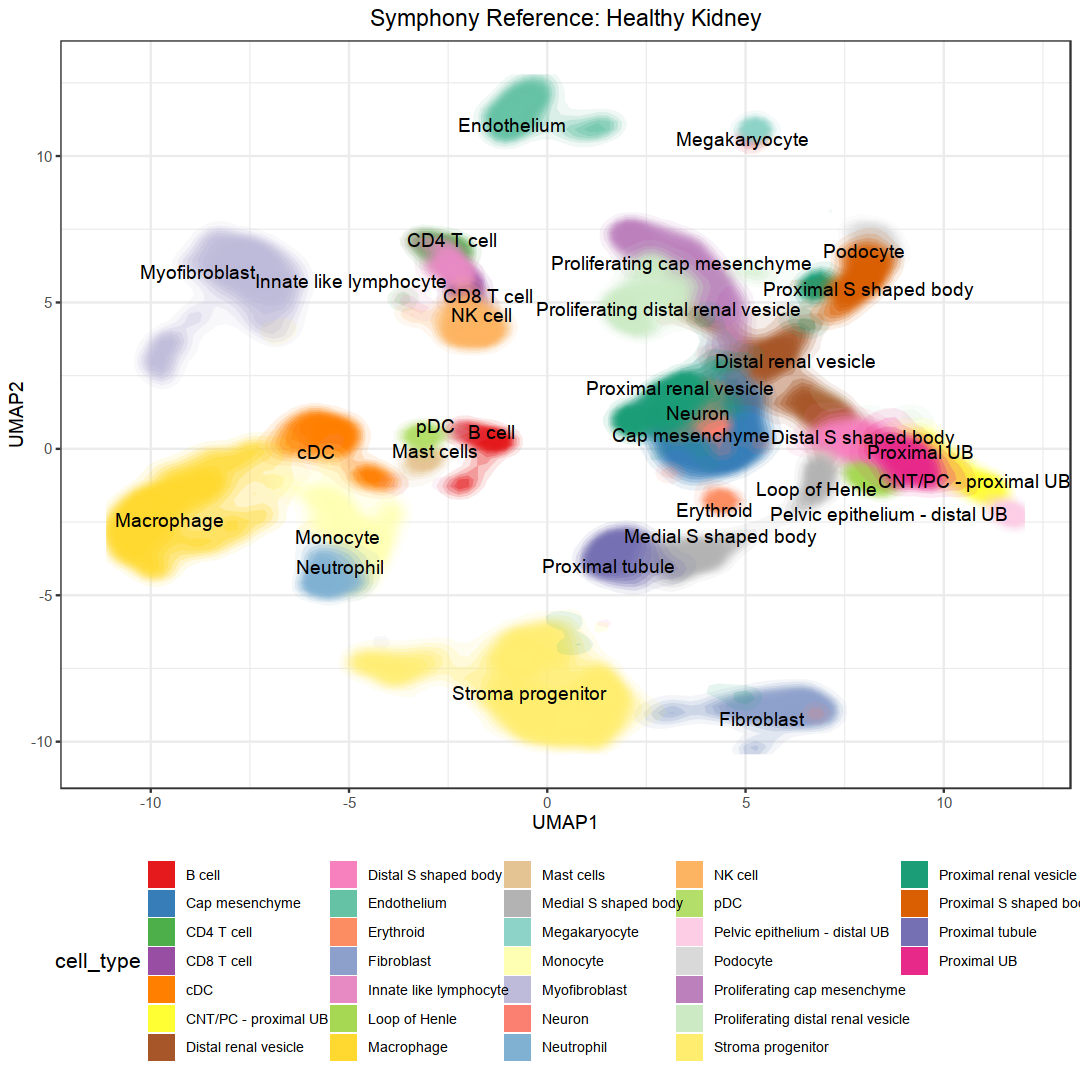

In [30]:
fig.size(9, 9)
p = plotReference(ref_kidney,
                   as.density = TRUE,      # plot density or individual cells
                   bins = 14,              # if density, nbins parameter for stat_density_2d
                   bandwidth = 1,          # if density, bandwidth parameter for stat_density_2d
                   title = "Symphony Reference: Healthy Kidney",    # Plot title
                   color.by = 'cell_type',     # metadata column name for cell type labels
                   celltype.colors = assort.colors, # custom color palette
                   show.legend = TRUE,     # Show cell type legend
                   show.labels = TRUE,    # Show cell type labels
                   show.centroids = FALSE) # Plot soft cluster centroid locations) 
p

# Additional Symphony References

The following references are not directly featured in the Symphony manuscript, but are available for download and mapping.

* Fibroblast Atlas (Korsunsky et al., *bioRxiv*, 2021)
* Cross-tissue Immune Atlas (Zhang et al., *Genome Medicine*, 2021)
* Tabula Muris Senis

## The Fibroblast Atlas

This single-cell atlas profiles human fibroblasts across inflammatory diseases in the lung, gut, synovium, and salivary gland. 

Preprint (Korsunsky et al., 2021): "Cross-tissue, single-cell stromal atlas identifies shared pathological fibroblast phenotypes in four chronic inflammatory diseases"; https://www.biorxiv.org/content/10.1101/2021.01.11.426253v2

Usage: https://github.com/immunogenomics/fibroblastlas

## Cross-tissue Immune Atlas

This single-cell atlas profiles human immune cells across inflammatory diseases.

Paper: Zhang, F., Mears, J.R., Shakib, L. et al. IFN-γ and TNF-α drive a CXCL10+ CCL2+ macrophage phenotype expanded in severe COVID-19 lungs and inflammatory diseases with tissue inflammation. Genome Med 13, 64 (2021). https://doi.org/10.1186/s13073-021-00881-3

Usage: [Example notebook (from Zhang et al., 2021)](https://github.com/immunogenomics/inflamedtissue_covid19_reference/blob/master/code/Map_Sepsis_to_FanImmuneReference_using_Symphony_Notebook.ipynb)

## Mapping to Tabula Muris Senis Atlas

This section demonstrates mapping cells onto the Tabula Muris Senis (FACS) reference.

Original paper: The Tabula Muris Consortium. A single-cell transcriptomic atlas characterizes ageing tissues in the mouse. Nature 583, 590–595 (2020). https://doi.org/10.1038/s41586-020-2496-1

In [31]:
reference_facs = readRDS('../pre-built_references/TMS_facs_reference.rds')

Plot reference

In [32]:
# Visualize reference
library(RColorBrewer)
tms.colors = c(brewer.pal(name="Dark2", n = 8), brewer.pal(name="Paired", n = 12),
            brewer.pal(name="Set1", n = 9), brewer.pal(name="Set2", n = 8),
            brewer.pal(name='Accent', n = 7), brewer.pal(name='Set3', n = 12))

umap_labels = cbind(reference_facs$meta_data, reference_facs$umap$embedding)

Plot by donor

null device 
          1

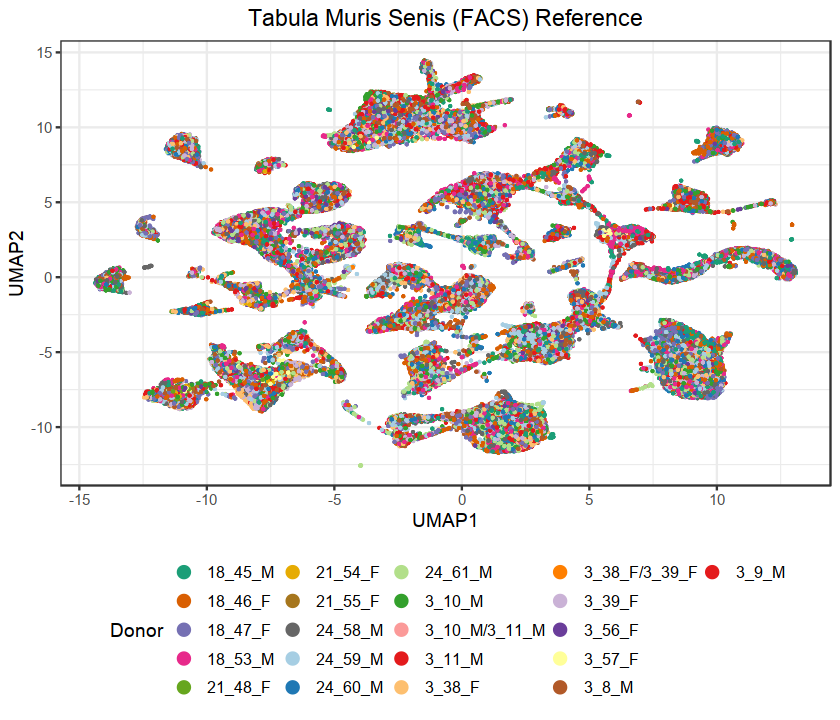

In [33]:
# Plot UMAP visualization
fig.size(6, 7)

p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = mouse.id)) +
    geom_point_rast(size = 0.4) +
    theme_bw() +
    labs(title = 'Tabula Muris Senis (FACS) Reference', color = 'Donor') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="bottom") +
    theme(legend.text = element_text(size=9)) + 
    scale_colour_manual(values = tms.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3)))
print(p)
dev.off()
p

Plot by tissue

Adding missing grouping variables: `tissue`



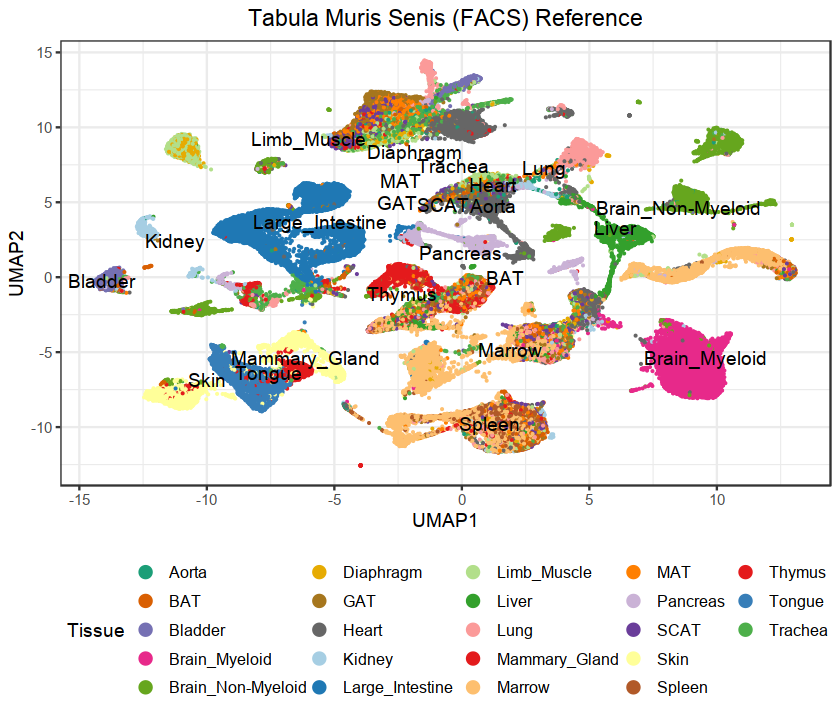

In [34]:
# Plot UMAP visualization
fig.size(6, 7)

# Add cell type labels (at median coordinate per cell type)
labels.cent = umap_labels %>% 
    dplyr::group_by(tissue) %>% # group_by_at takes variable column name
    dplyr::select(UMAP1, UMAP2) %>% 
    dplyr::summarize_all(median)

p_tissue = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = tissue)) +
    geom_point(size = 0.1) +
    theme_bw() +
    labs(title = 'Tabula Muris Senis (FACS) Reference', color = 'Tissue') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="bottom") +
    theme(legend.text = element_text(size=9)) + 
    scale_colour_manual(values = tms.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3)))
        
p_tissue = p_tissue + ggrepel::geom_text_repel(data = labels.cent, aes(x= UMAP1, y = UMAP2, label = tissue), 
                    segment.alpha = 0.5, segment.size = 0.2, box.padding = 0.01, color = 'black')
p_tissue

Plot by cell ontology class

Adding missing grouping variables: `cell_ontology_class`



null device 
          1

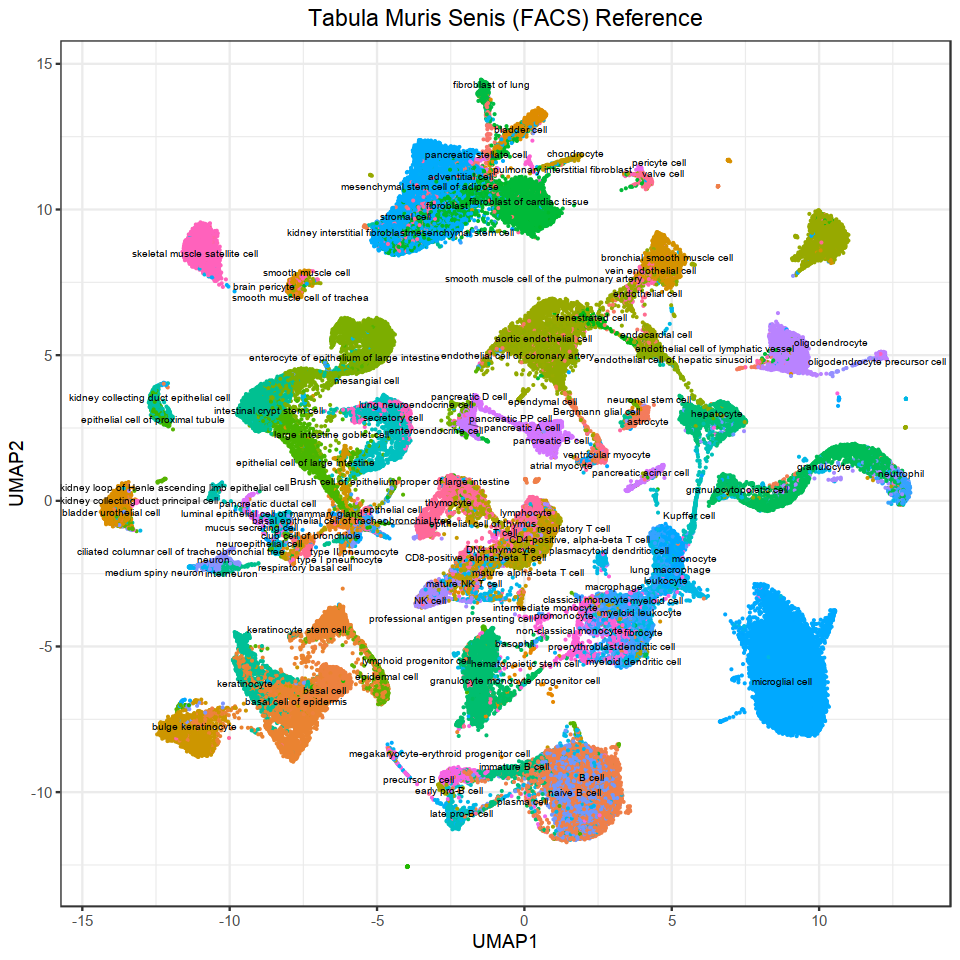

In [35]:
# Plot UMAP visualization
fig.size(8, 8)

# Add cell type labels (at median coordinate per cell type)
labels.cent = umap_labels %>% 
    dplyr::group_by(cell_ontology_class) %>% # group_by_at takes variable column name
    dplyr::select(UMAP1, UMAP2) %>% 
    dplyr::summarize_all(median)

p = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_ontology_class)) +
    geom_point(size = 0.1) +
    theme_bw() +
    labs(title = 'Tabula Muris Senis (FACS) Reference', color = 'Cell ontology class') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="none") +
    theme(legend.text = element_text(size=9)) + 
    guides(colour = guide_legend(override.aes = list(size = 3)))

p = p + ggrepel::geom_text_repel(data = labels.cent, aes(x= UMAP1, y = UMAP2, label = cell_ontology_class), 
                    size = 2, segment.alpha = 0.5, segment.size = 0.2, box.padding = 0.01, color = 'black', max.overlaps = 40)

print(p)
dev.off()
p

### Map query

As an example, let's map the Baron et al. mouse pancreatic islet cell data (mouse cells from the pancreatic islet example above)!

In [36]:
## Read in Baron mouse data
mouse = readRDS('data/baron-mouse.rds')

mouse_exp = Matrix(mouse@assays[['data']][['counts']], sparse = TRUE)
mouse_exp = as(mouse_exp, "dgCMatrix")
mouse_metadata = mouse@colData

In [37]:
mouse_exp %>% dim()
colnames(mouse_metadata)[1] = 'donor'
mouse_metadata$cell_type = mouse_metadata$cell_type1 %>%
        plyr::mapvalues(from = c('quiescent_stellate', 'macrophage', 'immune_other', 'activated_stellate', 'B_cell', 'T_cell'),
                         to = c('stellate', 'immune', 'immune', 'stellate', 'immune', 'immune'))
mouse_metadata = as.data.frame(mouse_metadata)[ ,c('donor', 'cell_type1', 'total_features', 'cell_type')]

[1] 14878  1886

In [38]:
query = mapQuery(mouse_exp, metadata_query = mouse_metadata, 
                 ref_obj = reference_facs, vars = 'donor', do_normalize = TRUE, do_umap = TRUE)

Normalizing

Scaling and synchronizing query gene expression

Found 1970 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



In [39]:
reference_facs$vargenes$symbol %>% length()

[1] 2855

Looks like only 1970 of the 2855 reference variable genes are named using the same gene symbol in the query. Therefore, the mapping is likely not ideal and so we won't go too deep into accuracy metrics.

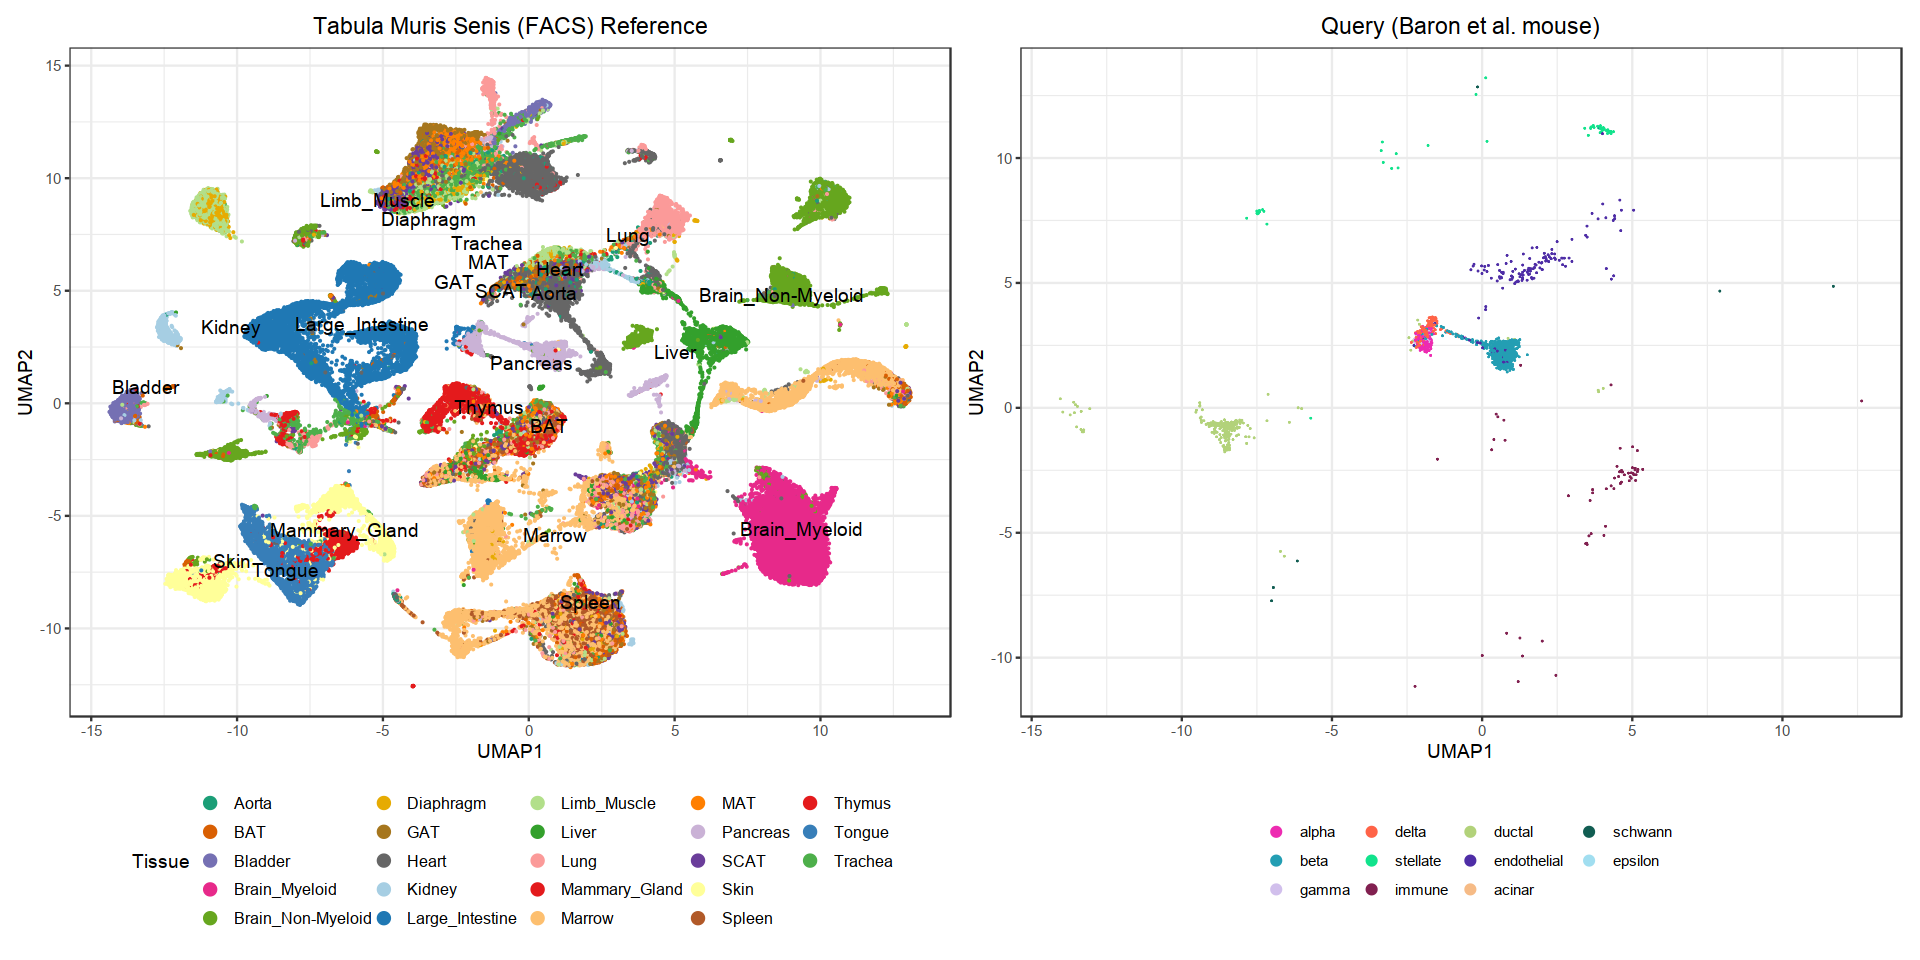

In [40]:
umap_combined_labels = cbind(query$meta_data, query$umap)
fig.size(8, 16)
q = umap_combined_labels %>%
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.6, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Query (Baron et al. mouse)', color = '') + 
    theme(plot.title = element_text(hjust = 0.5), legend.position = "bottom") +
    scale_colour_manual(values = pancreas_colors) +
    guides(colour = guide_legend(override.aes = list(size = 3))) +
    theme(strip.text.x = element_text(size=13))
p_tissue + q

# All done!
And that's a wrap! If you run into any questions, feel free to post on GitHub and we will get back to you as soon as possible.

In [41]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.1         RColorBrewer_1.1-2      ggrastr_0.2.3          
 [4] ggthemes_4.2.4          plyr_1.8.6              Matrix_1.3-3           
 [7] matrixStats_0.59.0      forcats_0.5.1           stringr_1.4.0          
[10] dplyr_1.0.7             purrr_